In [27]:
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.service import Service
import requests
import time
import datetime
import smtplib
import csv
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from scikitplot.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from torch.utils.data import Dataset, DataLoader
import sklearn.metrics as metrics
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample


In [3]:
# location of chrome driver  = "C:\Program Files (x86)\chromedriver.exe"

#let's mine some product data from Amazon
# my friend purchased this mouse recently,so I decided to see what other users think of it

#establish the connection                                                                                                                                                     
s = Service("C:\Program Files (x86)\chromedriver.exe")
driver = webdriver.Chrome(service=s)
url = 'https://www.amazon.com/Logitech-MX-Master-3S-Pale/dp/B09HMKFDXC/ref=cm_cr_arp_d_product_top?ie=UTF8'
driver.get(url)

#let's scrape general prodcut info! It will be used to scale up the research later
prod = (driver.find_element(by ="id", value ="productTitle")).text
asin = ((driver.find_element(By.XPATH,"//input[@id='attach-baseAsin']")).get_attribute("value"))
st_temp = (driver.find_element(by ="id", value ="acrPopover")).get_attribute("title")
prod_rating = re.findall(r"(\d+\.*\d*) out", st_temp)[0]

#obtaining the link taking us to all ratings
reviews_link1 = driver.find_element(By.XPATH,"//body/div[@id='a-page']/div[@id='dp']/div[@id='dp-container']/div[@id='customer-reviews_feature_div']/div[@id='reviewsMedley']/div[1]/div[2]/div[1]/div[2]/span[3]/span[1]/div[2]/div[1]/div[1]/div[6]/a[1]")
reviews_link2 = reviews_link1.get_attribute("href")

#closing this driver
driver.quit()

In [23]:
#let's scrape individual reviews and ratings awarded by customers

stars = []
reviews = []

#this product has plenty of review pages. We can form the set as big as we like
for i in range(300):
        rev_p1 = reviews_link2+ "&pageNumber=" + str(i)
        rev_p1
        driver2 = webdriver.Chrome(service=s)
        driver2.get(rev_p1)

        soup_rev = BeautifulSoup(driver2.page_source) 
        for i in soup_rev.findAll("div",{'class':"a-section celwidget"}):
                reviews.append((i.find("span",{'data-hook':"review-body"})).text)
                stars.append(((i.find("span",{'class':"a-icon-alt"})).text)[0])
        driver2.quit()         

In [63]:

df_rev = pd.DataFrame({'Reviews': reviews, 'Stars': stars})
df_rev.head()

,Reviews,Stars
0,\nPros:Scrolling 5/5-Scrolling on Windows has ...,5
1,\nI wish that there was a fusion between the L...,5
2,\nI've been using this mouse for a year and I ...,5
3,\nPros:1.) The fact that the scroll wheel is a...,3
4,\nI've been using the Logitech Performance MX ...,5


In [64]:
df_rev.head()

,Reviews,Stars
0,\nPros:Scrolling 5/5-Scrolling on Windows has ...,5
1,\nI wish that there was a fusion between the L...,5
2,\nI've been using this mouse for a year and I ...,5
3,\nPros:1.) The fact that the scroll wheel is a...,3
4,\nI've been using the Logitech Performance MX ...,5


In [71]:
#writing down the data to csv
df_rev.to_csv('dataframe_reviews_300.csv', index=False)

In [3]:

df_rev = pd.read_csv('dataframe_reviews_300.csv')
df_rev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1342 entries, 0 to 1341
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Reviews  1341 non-null   object
 1   Stars    1342 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 21.1+ KB


In [42]:
# clean up the dataset
stop_words = stopwords.words('english')

df_rev['Low_rev'] = df_rev['Reviews'].str.lower()
df_rev['Low_rev'] = df_rev['Low_rev'].astype(str).replace(r'[^a-zA-z0-9\s]', '', regex=True)
df_rev['Low_rev'] = df_rev['Low_rev'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

df_rev.head()

,Reviews,Stars,Low_rev
0,\nPros:Scrolling 5/5-Scrolling on Windows has ...,5,prosscrolling 55scrolling windows always light...
1,\nI wish that there was a fusion between the L...,5,wish fusion logitech g502 hero wireless mouse ...
2,\nI've been using this mouse for a year and I ...,5,ive using mouse year say exceeded expectations...
3,\nPros:1.) The fact that the scroll wheel is a...,3,pros1 fact scroll wheel metal least gets rid s...
4,\nI've been using the Logitech Performance MX ...,5,ive using logitech performance mx mx master mo...


5    844
4    155
1    150
3    107
2     86
Name: Stars, dtype: int64


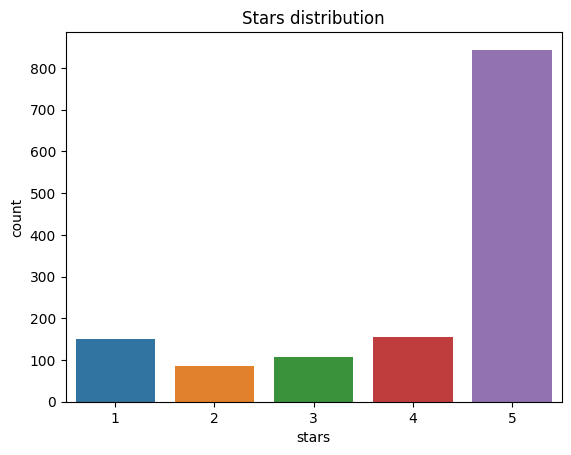

In [10]:
#lets create a visual of star rating distribution

sns.countplot(x='Stars', data=df_rev)
plt.title('Stars distribution')
plt.xlabel('stars')
plt.ylabel('count')
print(df_rev['Stars'].value_counts())
plt.show()


In [47]:
#undersampling

st_1 = df_rev[df_rev['Stars']==1]
st_2 = df_rev[df_rev['Stars']==2]
st_3 = df_rev[df_rev['Stars']==3]
st_4 = df_rev[df_rev['Stars']==4]
st_5 = df_rev[df_rev['Stars']==5]

print(st_1.shape, st_2.shape, st_3.shape, st_4.shape, st_5.shape)

count_5 = st_5.shape[0]
count_4 = st_4.shape[0]
count_3 = st_3.shape[0]
count_2 = st_2.shape[0]
count_1 = st_1.shape[0]

print("Count 5", count_5)

df_class_5_under = st_5.sample(count_2)
df_test_under = pd.concat([df_class_5_under, st_1, st_2, st_3, st_4], axis=0)

print('Random under-sampling:')
print(df_test_under.Stars.value_counts())

(150, 3) (86, 3) (107, 3) (155, 3) (844, 3)
Count 5 844
Random under-sampling:
4    155
1    150
3    107
5     86
2     86
Name: Stars, dtype: int64


In [32]:


columns = df_rev.columns.tolist()
columns = [i for i in columns if i not in ["Stars"]]
label = "Stars"
X = df_rev[columns]
Y = df_rev[label]

df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_test_over.Churn.value_counts())


# smote = SMOTE()
# X_resampled, y_resampled = smote.fit_resample(X, Y)
# resampled_df = pd.DataFrame({'label': y_resampled, 'value': X_resampled.flatten()})

# print(resampled_df)


# vectorizer = CountVectorizer()
# vectorizer.fit(X.values.ravel())
# X_t=vectorizer.transform(X.values.ravel())
# X_t=X_t.toarray()

# x_t = pd.DataFrame(X_t)
# X_resample, y_resampled = SMOTE().fit_resample(X_t, Y)

# X_resample.value_counts()

# smote = SMOTE(sampling_strategy='minority')
# X_sm, Y_sm = smote.fit_resample(X, Y)

# Y_sm.value_counts()




# smk = SMOTETomek(random_state=42)
# X_res,y_res=smk.fit_resample(X,Y)
# print(X.shape)
# print(Y.shape)

ValueError: could not convert string to float: '\nPros:Scrolling 5/5-Scrolling on Windows has always be light years behind Mac - even when using a track pad on Windows vs a stepped scroll wheel, the scroll feels jerky and inconsistent while Macs always feel buttery smooth and fluid no matter what device you use. This mouse with the scroll wheel in free spin "MagSpeed" mode is the closest I\'ve ever felt a Windows machine scroll like a Mac. It really is super nice. I almost never put it into the stepped mode. I see a lot of comments talking about inconsistent scrolling on this mouse and I cannot say I have experienced that. For context I am using the Lightspeed connector and not Bluetooth, which I\'m sure plays a large factor with the free spin. Let\'s look at the math behind that. Logitech claims Lightspeed has a 1ms response time, while bluetooth can be as low as 34ms but is often times more around 100-300ms. In "MagSpeed" mode at full spin speed, this mouse will do 1000 lines per second. So yes, for your computer to ingest those line signals it\'s going to need a 1ms response rate. I am also using Logitech\'s Options+ software which may also play a role in scrolling stability.Ergonomics 4/5-Ergonomics feel really nice to me, but borderline too small. My glove size is between M and L (or 8 and 9), so if you are an L or larger hand maybe this won\'t work for you, but everyone\'s comfort is different. The thumb and palm sculpting is really nice and fills the hand nicely (depending on your size). The matte finish texturing also feels nice, I just hope it doesn\'t deteriorate over time.Logitech Options+ Software 5/5-Being able to program the button map per application is a game changer (for me) and has really improved my work flow. DPI can also be adjusted here.Gesture Button 5/5-The lower thumb "gesture" button gives back Mac like gestures to mouse users, something I sorta forgot I was missing but use it all the time now.DPI 5/5-I found out 8k DPI is too high for my monitor, which was one of the deciding factors for me between this and the MX 3. I have a 49inch ultrawide 32:9 ratio monitor at 5120X1440 resolution, and I could feel the lower DPI of my old mouse on this monitor. However this one set to 8k is crazy fast - way too fast - so I currently have it set to 55% speed. Again lets look at the math - if you have a 8k monitor, this mouse set to max DPI is going to get from the left most side of the screen to the right most side in just 1inch of mouse travel. That\'s fast - you may find that 8K is overkill for your needs. That said, this is all easily adjustable in the Options+ software and it does feel WAY smoother than any mouse or trackpad I\'ve used. I\'ve yet to use this on glass - I\'m sure the DPI helps in that regard.Click 4/5-I honestly thought I wouldn\'t like having a silent click feel, and I like clicky keyboards as well, but it\'s growing on me. Enough so to make me rethink the type of keyboard I\'m using. Click feel and sound ultimately comes down to preference, so all I can say is you feel the click, but it\'s barely audible. Search youtube or even Amazon reviews, I\'ve seen sound comparisons with this mouse so judge for yourself.Cons:Ergonomics:-The lost point above is due to size - my fourth finger does rest on the desk, which was true of my previous mouse as well so I\'m used to it but the experience would be better if there was a rest point or wing on the right side of this mouse. I don\'t know, this is again preference and hold style but for me I think I would have given a higher score for ergonomics if my pinky didn\'t touch the desk.Click:-Still on the fence on how silent the click is. Feel is good, sound is... well not there. So if you\'re used to a satisfying click sound this is going to be jarring.\n'

In [48]:
#let's see top 5 most frequent words in the set
freq_top = pd.Series(' '.join(df_test_under['Low_rev']).lower().split()).value_counts()[:5]
freq_top

mouse       1271
scroll       350
use          319
wheel        311
logitech     290
dtype: int64

In [ ]:
#the dataset is gravitating towards 5* largely
#good news for the brand, not so good for us because the set is imbalanced
#lets balance it


In [74]:
df_rev.drop('low_reviews',axis=1,inplace=True)

In [127]:
X = df_rev['low_reviews']
y = df_rev['Stars']

In [128]:
bow_transformer = CountVectorizer().fit(X)
X = bow_transformer.transform(X)


In [129]:
print('Shape of Sparse Matrix: ', X.shape)
print('Amount of Non-Zero occurrences: ', X.nnz)

# Percentage of non-zero values
density = (100.0 * X.nnz / (X.shape[0] * X.shape[1]))
print('Density: {}'.format((density)))

Shape of Sparse Matrix:  (30, 1514)
Amount of Non-Zero occurrences:  4519
Density: 9.94936151475121


In [130]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
nb = MultinomialNB()
nb.fit(X_train, y_train)
preds = nb.predict(X_test)

In [131]:
print(confusion_matrix(y_test, preds))
print('\n')
print(classification_report(y_test, preds))
print(metrics.accuracy_score(y_test, preds))

[[0 0]
 [1 8]]


              precision    recall  f1-score   support

           3       0.00      0.00      0.00         0
           5       1.00      0.89      0.94         9

    accuracy                           0.89         9
   macro avg       0.50      0.44      0.47         9
weighted avg       1.00      0.89      0.94         9

0.8888888888888888


c:\Users\lepeh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\lepeh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\lepeh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

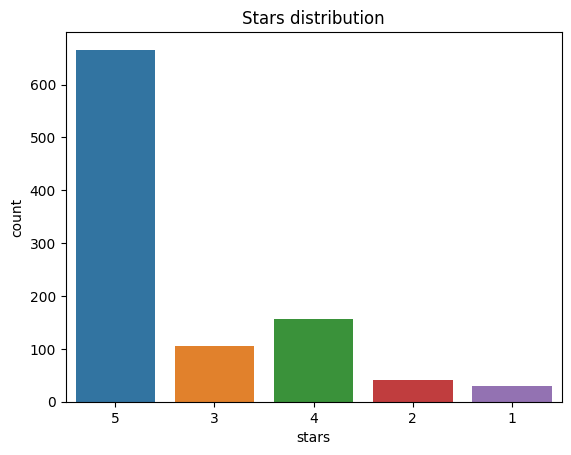

In [79]:
X_train, X_test, y_train, y_test = train_test_split(df_rev['low_reviews'], df_rev['Stars'], test_size=0.2, random_state=42)


In [80]:
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [84]:
batch_size = 32
learning_rate = 0.001
num_epochs = 10
train_dataset = Dataset(X_train.toarray(), y_train.values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = Dataset(X_test.toarray(), y_test.values)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

TypeError: Dataset() takes no arguments

In [82]:
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.695


In [7]:
# #write scraped data bout the product to the file. reviews and stars go into separate file

# header = ['Title', 'ASIN','Price', 'Av. Rating','Num. ratings','Date']
# data = [product, asin,price, stars_overall, num_ratings,thedate]

# with open('prod.csv', 'a+', newline='', encoding='UTF8') as f:
#     writer = csv.writer(f)
#     writer.writerow(header)
#     writer.writerow(data)

In [8]:
# header = ['Review', 'Stars']
# data = list(zip(reviews, stars))

# with open('reviews.csv', 'a+', newline='', encoding='UTF8') as f:
#     writer = csv.writer(f)
#     writer.writerow(['Review', 'Stars'])
#     for row in data:
#         writer.writerow(row)


In [9]:
df_full = pd.read_csv("reviews.csv")
df = pd.read_csv("reviews.csv")
df.drop(['Stars'],axis=1,inplace=True)
df.shape

(100, 1)

In [102]:
newl = [['banana','1234'],['tomato', 'cu234cucmber','po56565tato'], ['strawberry','b1n_a!na', 'peaches']]
kl =[]
for j in newl:
    for i in j:
        y = re.sub(r'[^a-zA-Z]', '', i)
        kl.append(y)
print(kl)    


['banana', '', 'tomato', 'cucucmber', 'potato', 'strawberry', 'bnana', 'peaches']


In [109]:
def cleanup(rev):
    rev_cl = rev.lower().split()
    alphanum =[]
    for i in rev_cl:
        new_j = re.sub(r'[^a-zA-Z]', '', i)
        alphanum.append(new_j)
    stopw = set(stopwords.words("english"))   
    nostop = []
    for i in alphanum:
        if i not in stopw:
           nostop.append(i) 

    return nostop


In [1]:
# cleaned_reviews = []

# df['low_reviews'] = df['Review'].apply(lambda x: cleanup(x))
df['low_reviews'] = df['Review'].apply(cleanup)

NameError: name 'df' is not defined

In [51]:
df.drop(['low_reviews'],axis=1,inplace=True)

In [108]:
df.head(15)

,Review,stars_predicted,original_stars,low_reviews
0,\nPros:Scrolling 5/5-Scrolling on Windows has ...,4,5,"[prosscrolling, scrolling, on, windows, has, a..."
1,\nI've been using this mouse for a year and I ...,5,5,"[ive, been, using, this, mouse, for, a, year, ..."
2,\nI wish that there was a fusion between the L...,3,5,"[i, wish, that, there, was, a, fusion, between..."
3,\nPros:1.) The fact that the scroll wheel is a...,2,3,"[pros, the, fact, that, the, scroll, wheel, is..."
4,\nI've been using the Logitech Performance MX ...,4,5,"[ive, been, using, the, logitech, performance,..."
5,\nI've grown up with Logitech gaming periphera...,4,5,"[ive, grown, up, with, logitech, gaming, perip..."
6,\nThis mouse is definitely my favorite one to ...,5,5,"[this, mouse, is, definitely, my, favorite, on..."
7,"\nI've never spent $99 for a mouse, but after ...",3,5,"[ive, never, spent, , for, a, mouse, but, afte..."
8,\nBought this to stop using my Logitech ultra ...,1,5,"[bought, this, to, stop, using, my, logitech, ..."
9,\nI work from home and have my personal comput...,5,5,"[i, work, from, home, and, have, my, personal,..."


In [ ]:
df.drop

In [10]:
# tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
# model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

In [11]:
# def sentiment(review):
#     tokens = tokenizer.encode(review, return_tensors='pt')
#     result = model(tokens)
#     return int(torch.argmax(result.logits))+1

In [12]:
# df['stars_predicted'] = df['Review'].apply(lambda x: sentiment(x[:100]))

In [ ]:
# extr = df_full['Stars']
# extr.head(10)
# df.insert(2,'original_stars',extr)
# # df.drop(['Stars'],axis=1,inplace=True)
# df.head(15)

In [22]:

# sns.countplot(x='stars_predicted', data=df)
# plt.title('Predicted stars')
# plt.xlabel('pred stars')
# plt.ylabel('count')
# plt.show()

# df_rev['low_reviews'] = df_rev['Reviews'].apply(lambda x: cleanup(x))
# df_rev.head()